In [2]:
import torch
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose, ToTensor, Normalize
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


In [3]:
dataset = load_dataset("akhmedsakip/music-berkeley-emotions")

In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['audio', 'label'],
        num_rows: 1392
    })
    test: Dataset({
        features: ['audio', 'label'],
        num_rows: 246
    })
})

In [236]:
def audio_to_melspectrogram(waveform, sr=22050):
    """
    Converts waveform audio data to a Mel-spectrogram.
    
    Parameters:
    - waveform: Audio waveform data as a NumPy array.
    - sr: The sample rate of the audio.
    
    Returns:
    - mels_db: The Mel-spectrogram in dB.
    """
    # Generate the Mel-spectrogram
    mels = librosa.feature.melspectrogram(y=waveform, sr=sr, n_mels=128)
    mels_db = librosa.power_to_db(mels, ref=np.max)
    return mels_db

In [237]:
# Assuming the first sample in the training set for demonstration
sample = dataset['train'][0]

# Extract waveform and sample rate
waveform = sample['audio']['array']
sr = sample['audio']['sampling_rate']

# Now, convert to Mel-spectrogram
mels_db = audio_to_melspectrogram(waveform, sr=sr)

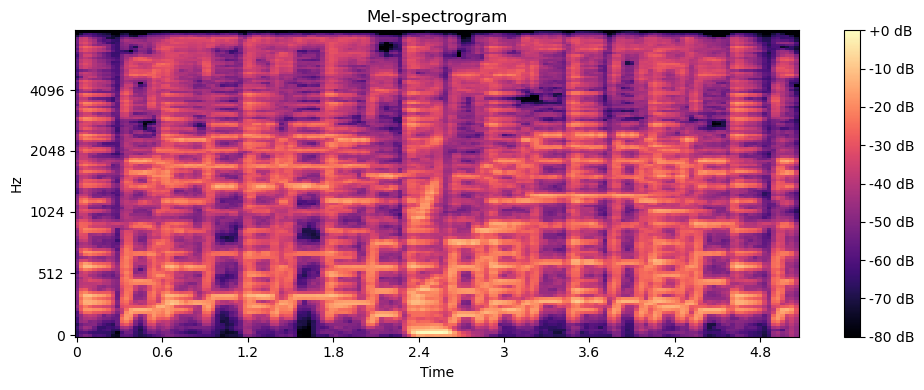

In [238]:
# Plot the Mel-spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(mels_db, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-spectrogram')
plt.tight_layout()
plt.show()

In [245]:
class AudioDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        waveform = self.dataset[idx]['audio']['array']
        sr = self.dataset[idx]['audio']['sampling_rate']
        label = self.dataset[idx]['label']
    
        mels_db = audio_to_melspectrogram(waveform, sr=sr)
    
        # Apply any specified transform
        if self.transform:
            mels_db = self.transform(mels_db)
    
        # Convert mels_db to the correct shape (C, H, W) and type (torch.Tensor)
        mels_db_tensor = torch.tensor(mels_db).float().unsqueeze(0)  # Add channel dimension
    
        # Pad the Mel-spectrogram to ensure a fixed size, e.g., [1, 128, 160]
        mels_db_tensor = F.pad(mels_db_tensor, (0, max(0, 160 - mels_db_tensor.shape[2]), 0, 0), "constant", 0)
    
        return mels_db_tensor, label


In [246]:
def pad_sequence(batch):
    # Get the maximum length of the sequences in the batch
    max_length = max(x.shape[2] for x, _ in batch)  # Assuming x is [batch, channels, seq_len]
    
    # Initialize padded batch and labels list
    padded_batch = []
    labels = []
    for x, y in batch:
        # Number of padding operations required
        padding = max_length - x.shape[2]
        
        # Apply padding to the sequence if necessary
        if padding > 0:
            # Pad the sequence at the last dimension (time steps)
            padded_seq = F.pad(x, pad=(0, padding), mode='constant', value=0)
        else:
            padded_seq = x
        
        padded_batch.append(padded_seq)
        labels.append(y)
    
    # Stack the sequences and labels to create batch tensors
    padded_batch = torch.stack(padded_batch)
    labels = torch.tensor(labels, dtype=torch.long)
    
    return padded_batch, labels

In [247]:
# Example split (assuming dataset is already loaded and accessible as `dataset`)
train_dataset = AudioDataset(dataset['train'])
test_dataset = AudioDataset(dataset['test'])

# Use the custom collate function in your DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=pad_sequence)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=pad_sequence)

In [248]:
class CNNModel(nn.Module):
    def __init__(self, num_classes=13):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self._to_linear = None  # Will be set by _calculate_to_linear
        self.num_classes = num_classes
        # The line below is commented out to adjust for external call
        #self._calculate_to_linear([1, 128, 160])  # This will be called externally

        # Placeholder for fc layer, actual initialization will be done by _calculate_to_linear
        self.fc = None

    def _calculate_to_linear(self, sample_input_shape, device):
        dummy_input = torch.rand(sample_input_shape, device=device)
        output = self._forward_features(dummy_input)
        self._to_linear = int(output.numel() / output.shape[0])  # Cast to int
        self.fc = nn.Linear(self._to_linear, self.num_classes)  # This should now work without error


    def _forward_features(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        return x

    def forward(self, x):
        x = self._forward_features(x)
        x = x.view(-1, self._to_linear)  # Flatten the tensor for the fc layer
        x = self.fc(x)
        return x


In [249]:
# Assuming the dataset has 13 classes
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNModel(num_classes=13)
model.to(device)  # Move the model to the device
# Now explicitly calling _calculate_to_linear with the device argument
model._calculate_to_linear([1, 1, 128, 160], device)

# Continue with criterion and optimizer definition
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [251]:
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=10):
    device = next(model.parameters()).device

    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0
        
        # Training loop
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()  # Zero the parameter gradients
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward and optimize
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        
        # Validation loop (optional, but recommended)
        model.eval()  # Set model to evaluate mode
        val_running_loss = 0.0
        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * inputs.size(0)
        
        val_epoch_loss = val_running_loss / len(test_loader.dataset)
        
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Test Loss: {val_epoch_loss:.4f}')

# Call the training function
train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=10)

RuntimeError: shape '[-1, 20480]' is invalid for input of size 753664